In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam,SGD
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import models
from keras.models import Model

In [2]:
data_dir=r'/Users/mohsenboughriou/Downloads/archive/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Potato'
classes=[class_name for class_name in os.listdir(data_dir) if not class_name.startswith('.')]
classes

['Potato___Early_Blight', 'Potato___Late_Blight', 'Potato___Healthy']

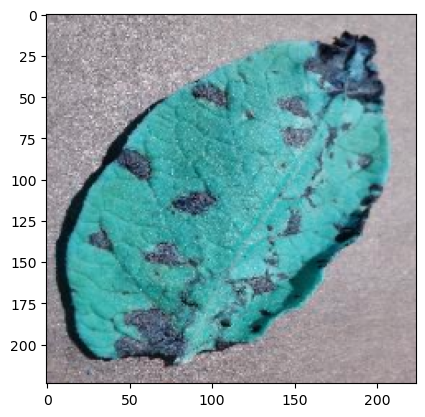

In [3]:
for category in classes:
    path=os.path.join(data_dir,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.resize(img_array,(224,224))
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break  
    break

In [4]:
training_data= []
def create_training_data():
    for category in classes:
        path=os.path.join(data_dir,category)
        class_num=classes.index(category)
        for img in os.listdir(path):
            img_array=cv2.imread(os.path.join(path,img))
            img_array=cv2.resize(img_array,(224,224))
            training_data.append([img_array,class_num])
create_training_data()

In [5]:
print(f'We have {len(training_data)} images.')

We have 2152 images.


In [6]:
X=[]
y=[]
for features, labels in training_data:
    X.append(features)
    y.append(labels)
X=np.array(X)/255
y=np.array(y)

In [7]:
print(np.shape(X))

(2152, 224, 224, 3)


In [8]:
y= keras.utils.to_categorical(y, num_classes=3)

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=27)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=27)

In [10]:
print(len(X_train))
print(len(X_test))
print(len(X_val))
print(len(y_train))
print(len(y_test))
print(len(y_val))

1829
162
161
1829
162
161


In [11]:
base_model = tf.keras.applications.VGG16(
    input_shape=(224,224,3), include_top=False,
    weights='imagenet', pooling=None,
    )

model = Sequential()
base_model.trainable=False
model.add(base_model)

model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=3, activation='softmax')) 
model.summary()

2023-12-17 08:46:39.588897: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-17 08:46:39.589508: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-17 08:46:39.589712: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-17 08:46:39.590382: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-17 08:46:39.590846: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         524544    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 256)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 3, 256)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 128)         0         
 g2D)                                                   

In [12]:
train_datagen=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,
                         shear_range = 0.2,zoom_range = 0.2,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                        rotation_range=40,fill_mode='nearest')

In [13]:
opt= Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history=model.fit(x=train_datagen.flow(X_train,y_train,seed=27,
        shuffle=False),  
    steps_per_epoch=X_train.shape[0] // 64,
    validation_data=(X_val,y_val),
                  epochs=20,
    validation_steps=len(X_val)//64)

Epoch 1/20


2023-12-17 08:46:52.790817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 34s 1s/step - loss: 0.9589 - accuracy: 0.6172 - val_loss: 0.5248 - val_accuracy: 0.7950
Epoch 2/20
28/28 [==============================] - 28s 980ms/step - loss: 0.4547 - accuracy: 0.8170 - val_loss: 0.2724 - val_accuracy: 0.9006
Epoch 3/20
28/28 [==============================] - 28s 978ms/step - loss: 0.3216 - accuracy: 0.8723 - val_loss: 0.3435 - val_accuracy: 0.8323
Epoch 4/20
28/28 [==============================] - 26s 936ms/step - loss: 0.2517 - accuracy: 0.8940 - val_loss: 0.2566 - val_accuracy: 0.9130
Epoch 5/20
28/28 [==============================] - 26s 936ms/step - loss: 0.2327 - accuracy: 0.9152 - val_loss: 0.1763 - val_accuracy: 0.9068
Epoch 6/20
28/28 [==============================] - 26s 917ms/step - loss: 0.2321 - accuracy: 0.9022 - val_loss: 0.1983 - val_accuracy: 0.9255
Epoch 7/20
28/28 [==============================] - 27s 962ms/step - loss: 0.1861 - accuracy: 0.9319 - val_loss: 0.1538 - val_accuracy: 0.9379
Epoch 8/20
28

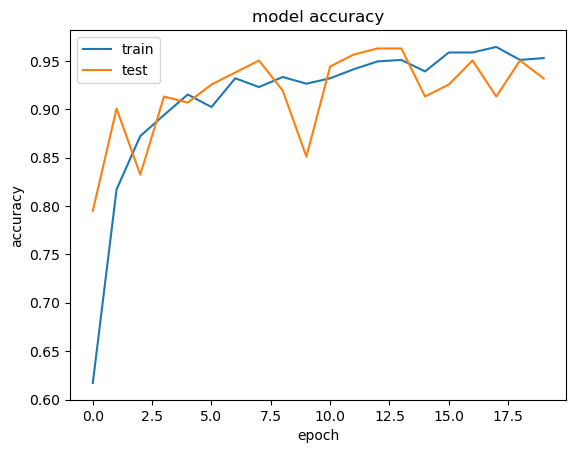

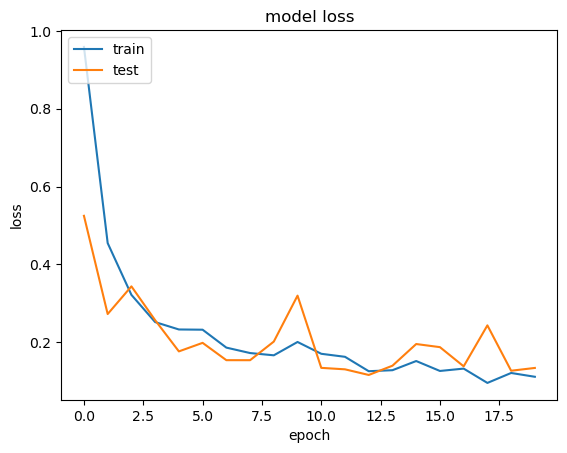

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
loss,accuracy= model.evaluate(X_test, y_test, batch_size=12) 

14/14 [==============================] - 3s 209ms/step - loss: 0.1517 - accuracy: 0.9383


In [16]:
model.save(r'/Users/mohsenboughriou/Downloads/archive/potato_disease')

INFO:tensorflow:Assets written to: /Users/mohsenboughriou/Downloads/archive/potato_disease/assets


INFO:tensorflow:Assets written to: /Users/mohsenboughriou/Downloads/archive/potato_disease/assets


## Enjoy your model!